In [42]:
import pandas as pd
%load_ext autoreload
%autoreload 2

from collections import Counter
import mirdata
import librosa
import stm
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from rhythmic_features import feature as f
from tqdm import tqdm
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, LeaveOneOut
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Groove Midi

_Jon Gillick, Adam Roberts, Jesse Engel, Douglas Eck, and David Bamman.
"Learning to Groove with Inverse Sequence Transformations."
International Conference on Machine Learning (ICML), 2019._

The Groove MIDI Dataset (GMD) is composed of 13.6 hours of aligned MIDI and (synthesized) audio of human-performed, tempo-aligned expressive drumming. The dataset contains 1,150 MIDI files and over 22,000 measures of drumming.

It could be used to classify fills or beats. Keep in mind that while fills tend to have a short duration (few seconds), beats tend to be longer. Therefore beats should be segmented in shorter chunks?


track.style -> a string style for the performance formatted as “primary/secondary” (e.g. rock/halftime, funk/purdieshuffle). The primary style comes from the Genre List below.

Genre List: afrobeat, afrocuban, blues, country, dance, funk, gospel, highlife, hiphop, jazz, latin, middleeastern, neworleans, pop, punk, reggae, rock, soul

For the following experiment the label will consist of the primary style only.

In [43]:
metadata = pd.read_csv("~/mir_datasets/groove_midi/info.csv")
metadata

,drummer,session,id,style,bpm,beat_type,time_signature,midi_filename,audio_filename,duration,split
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,27.872308,test
1,drummer1,drummer1/eval_session,drummer1/eval_session/10,soul/groove10,102,beat,4-4,drummer1/eval_session/10_soul-groove10_102_bea...,drummer1/eval_session/10_soul-groove10_102_bea...,37.691158,test
2,drummer1,drummer1/eval_session,drummer1/eval_session/2,funk/groove2,105,beat,4-4,drummer1/eval_session/2_funk-groove2_105_beat_...,drummer1/eval_session/2_funk-groove2_105_beat_...,36.351218,test
3,drummer1,drummer1/eval_session,drummer1/eval_session/3,soul/groove3,86,beat,4-4,drummer1/eval_session/3_soul-groove3_86_beat_4...,drummer1/eval_session/3_soul-groove3_86_beat_4...,44.716543,test
4,drummer1,drummer1/eval_session,drummer1/eval_session/4,soul/groove4,80,beat,4-4,drummer1/eval_session/4_soul-groove4_80_beat_4...,drummer1/eval_session/4_soul-groove4_80_beat_4...,47.987500,test
...,...,...,...,...,...,...,...,...,...,...,...
1145,drummer2,drummer2/session2,drummer2/session2/11,rock,130,beat,4-4,drummer2/session2/11_rock_130_beat_4-4.mid,NaN,1.909613,train
1146,drummer2,drummer2/session2,drummer2/session2/12,rock,130,beat,4-4,drummer2/session2/12_rock_130_beat_4-4.mid,NaN,1.808652,train
1147,drummer2,drummer2/session2,drummer2/session2/13,rock,130,beat,4-4,drummer2/session2/13_rock_130_beat_4-4.mid,NaN,1.864421,train
1148,drummer2,drummer2/session2,drummer2/session2/14,rock,130,beat,4-4,drummer2/session2/14_rock_130_beat_4-4.mid,NaN,1.875960,train


In [44]:
sum(metadata["audio_filename"].isna()) 

60

In [45]:
groove_dataset = mirdata.initialize("groove_midi")
# groove_dataset.download()
groove_dataset.validate()

100%|██████████| 1150/1150 [00:20<00:00, 55.79it/s] 
INFO: Success: the dataset is complete and all files are valid.
INFO: --------------------


({'metadata': {}, 'tracks': {}}, {'metadata': {}, 'tracks': {}})

In [50]:
features = []
labels = []
for _, track in tqdm(groove_dataset.load_tracks().items()):
    if track.beat_type == "beat":
        try:
            y, sr = librosa.load(track.audio_path, sr=None)
            stm_mean = stm.compute_stm(oss_autocorrelation=y, sr=sr, target_sr=8000, auto_cor_window_seconds=1, with_padding=True, auto_cor_norm_type="min-max")
            features.append(stm_mean[:100])
            labels.append(track.style.split("/")[0])
        except Exception as e:
            # exception encoutered with invalid audio_path
            print("Error:", e)
            continue

c = Counter(labels)
print(c)
encoded_labels = LabelEncoder().fit_transform(labels)
print(len(features))

  0%|          | 1/1150 [00:00<02:18,  8.32it/s]/home/stef/uni/internship/rythmic-pattern-analysis/stm.py:157: RuntimeWarning: invalid value encountered in divide
  if norm_type == "max":
  0%|          | 3/1150 [00:00<02:31,  7.57it/s]

Segment 0 contains only zeros
Autocorrelated segment 0 contains only zeros
oss_autocorrelation contains nans
Error: y must be finite everywhere


  1%|          | 10/1150 [00:01<02:40,  7.11it/s]

Segment 0 contains only zeros
Autocorrelated segment 0 contains only zeros
oss_autocorrelation contains nans
Error: y must be finite everywhere


  8%|▊         | 95/1150 [00:06<01:06, 15.81it/s]


KeyboardInterrupt: 

Cross-Validation Scores: [0.24615385 0.24806202 0.27131783 0.27131783 0.31007752]
Mean CV Accuracy: 0.2693858079904592


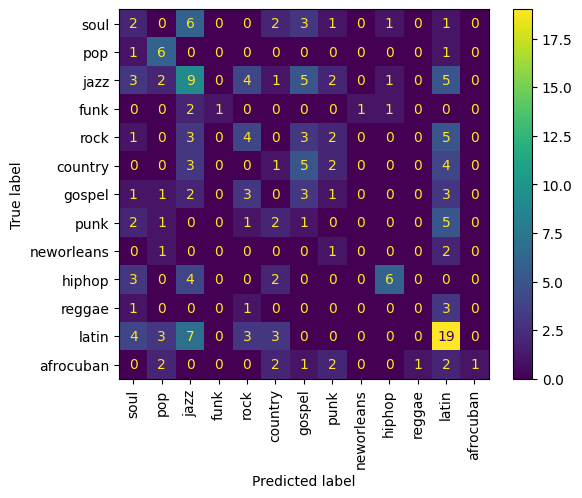

In [47]:
x_train, x_test, y_train, y_test = train_test_split(
    np.array(features), encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42
)

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine")
# rnn = RadiusNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=X_train, y=y_train)

k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(knn, features, encoded_labels, cv=k_fold, scoring="accuracy")

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

knn = KNeighborsClassifier(n_neighbors=7, metric="cosine").fit(X=x_train, y=y_train)
ConfusionMatrixDisplay.from_estimator(knn, x_test, y_test, display_labels=set(labels))
plt.xticks(rotation=90)
plt.show()